# Dark Energy Camera Legacy Survey (DECaLS)

- Telescope: Blanco 4m telescope, located at Cerro Tololo Inter-American Observatory
- Footprint: Basically Northern sky
- Bands: $g,\ r,\ z$
- Current Data Release: [DR7](http://legacysurvey.org) (DR8 will come out soon)
- Beautiful picture gallery: http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr7/gallery/
- Sky viewer: http://legacysurvey.org/viewer#NGC%204849

In [1]:
DECaLS_pixel_scale = 0.262 # arcsec/pixel

In [2]:
# Import packages
%matplotlib inline
import os
import urllib

import numpy as np

import matplotlib.pyplot as plt

from kungpao.display import display_single
import astropy.wcs as wcs
from astropy.io import fits
from astropy.table import Table, Column

## [`survey-bricks-dr7.fits.gz`](http://legacysurvey.org/dr7/files/#id4): Bricks: 0.25 deg * 0.25 deg

In [3]:
bricks = Table.read('/Users/jiaxuanli/Research/SideProjects/low-z-galaxy-survey/Catalogs/survey-bricks-dr7.fits', 
                    format='fits')
bricks[:10]

brickname,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nrex,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,ebv,trans_g,trans_r,trans_z,ext_g,ext_r,ext_z,wise_nobs [4],trans_wise [4],ext_w1,ext_w2,ext_w3,ext_w4
bytes8,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32
0001m002,0.125,-0.25,5,6,4,24968 .. 6051172,19578 .. 10474241,46299 .. 1907982,5644,2490,0,2434,523,188,9,1.6596661,1.2924303,1.068188,24.790665,24.645262,23.687878,24.586409,24.326422,23.293802,0.03402574,0.9041834,0.93440187,0.96275973,0.10935869,0.07366576,0.041205205,138 .. 12,0.99425024 .. 0.99971485,0.006260741,0.0038449126,0.0008199888,0.00030964034
0001m005,0.125,-0.5,4,6,3,165942 .. 765767,1201 .. 10280579,4213 .. 0,5567,1983,0,2672,644,253,15,1.6521722,1.2832937,1.0783478,24.678738,24.643381,23.544353,24.460396,24.32058,23.164818,0.04116949,0.8852634,0.9211858,0.955119,0.13231875,0.08913193,0.049856275,134 .. 13,0.9930473 .. 0.999655,0.0075751664,0.004652148,0.0009922094,0.00037463458
0001m007,0.125,-0.75,6,6,3,134912 .. 7403070,913 .. 7786008,4162 .. 0,5644,2042,0,2661,630,295,16,1.8400385,1.3273993,1.0783815,24.76929,24.548141,23.553368,24.58524,24.260008,23.17335,0.043467097,0.8792628,0.916975,0.9526745,0.13970324,0.09410624,0.052638642,135 .. 14,0.99266064 .. 0.99963576,0.007997993,0.004911825,0.0010475926,0.00039554492
0001m010,0.125,-1.0,7,4,3,21928 .. 10336513,41046 .. 3852408,37619 .. 0,5628,2194,0,2619,557,239,19,1.8105285,1.3227282,1.0430727,24.90124,24.564512,23.490965,24.711924,24.264574,23.082743,0.03797816,0.8936661,0.92706656,0.9585248,0.12206181,0.08222271,0.045991592,134 .. 12,0.9935845 .. 0.9996817,0.006987965,0.004291563,0.0009152605,0.0003456327
0001m012,0.125,-1.25,7,4,4,845 .. 10098566,1568 .. 5704276,2248 .. 0,5396,2211,0,2417,546,202,20,1.7765474,1.3105016,1.0556293,24.902866,24.66815,23.626198,24.711437,24.369892,23.225405,0.040892996,0.88598824,0.9216938,0.95541364,0.13143012,0.08853333,0.049521405,133 .. 13,0.99309385 .. 0.99965733,0.007524271,0.004620887,0.0009855377,0.00037210988
0001m015,0.125,-1.5,6,3,3,772 .. 10664263,2803 .. 0,3131 .. 0,5885,2411,0,2648,585,224,17,1.8524935,1.2560068,1.0615345,24.830956,24.599167,23.503721,24.65412,24.280567,23.114582,0.03661998,0.89726627,0.9295807,0.959978,0.11769664,0.07928227,0.04434682,133 .. 13,0.9938132 .. 0.9996931,0.0067380797,0.004138047,0.0008825524,0.00033326828
0001m017,0.125,-1.75,7,4,4,910 .. 10207630,3259 .. 0,3261 .. 0,5976,2372,0,2730,600,255,19,1.8344579,1.2413168,1.0495453,24.872885,24.67391,23.639816,24.693798,24.359129,23.235533,0.035687156,0.8997474,0.9313114,0.9609773,0.114698544,0.07726267,0.04321716,130 .. 12,0.99397033 .. 0.99970096,0.006566443,0.0040326184,0.00086007826,0.00032472334
0001m020,0.125,-2.0,6,3,4,4502 .. 10354889,9952 .. 436192,18717 .. 0,5931,2421,0,2647,603,252,8,1.8288481,1.2468685,1.0414103,24.838978,24.565796,23.648739,24.65044,24.264364,23.23956,0.03680654,0.8967709,0.929235,0.95977825,0.118296236,0.07968613,0.044572745,122 .. 12,0.9937818 .. 0.99969155,0.006772397,0.0041591595,0.00088702136,0.0003349514
0001m022,0.125,-2.25,7,4,4,1142 .. 10813421,2814 .. 2713220,5171 .. 2628781,5988,2454,0,2671,627,215,21,1.7899014,1.2888908,1.0323827,24.950603,24.590044,23.6739,24.761965,24.293253,23.255478,0.03654573,0.89746356,0.9297184,0.9600575,0.11745794,0.07912147,0.044256892,120 .. 10,0.9938257 .. 0.99969375,0.0067244703,0.0041296664,0.00088073895,0.0003325562


## Download the jpeg image of a given coordinate

In [4]:
# Generate DECaLS jpeg cutout url
def gen_url_decals_jpeg(ra_cen, dec_cen, size, bands, layer='decals-dr7', pixel_unit=False):
    '''Generate jpeg image url of given position.
    
    Parameters:
    -----------
    ra: float, RA (degrees)
    dec: float, DEC (degrees)
    size: float, image size (pixel)
    bands: string, such as 'r' or 'gri'
    layer: string, edition of data release
    pixel_unit: boolean. If true, size will be in pixel unit.

    Returns:
    -----------
    url: list of str, url of S18A image.  
    '''
    if pixel_unit:
        return ['http://legacysurvey.org/viewer/jpeg-cutout?ra=' 
                + str(ra_cen) 
                + '&dec=' 
                + str(dec_cen) 
                + '&layer=' 
                + layer 
                + '&size=' 
                + str(size) 
                + '&pixscale=' 
                + str(DECaLS_pixel_scale) 
                + '&bands=' 
                + bands]
    else:
        return ['http://legacysurvey.org/viewer/jpeg-cutout?ra=' 
                + str(ra_cen) 
                + '&dec=' 
                + str(dec_cen) 
                + '&layer=' 
                + layer 
                + '&size=' 
                + str(int(size/DECaLS_pixel_scale))
                + '&pixscale=' 
                + str(DECaLS_pixel_scale) 
                + '&bands=' 
                + bands]

In [5]:
ra = 217.419294 
dec = 0.366394

In [6]:
url = gen_url_decals_jpeg(ra, dec, 500, 'grz', layer='decals-dr7', pixel_unit=True)[0]
urllib.request.urlretrieve(url, filename='./decals_jpeg.jpg')

('./decals_jpeg.jpg', <http.client.HTTPMessage at 0x117865e80>)

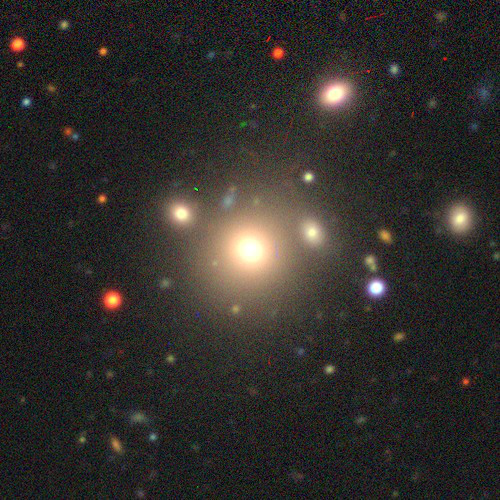

In [7]:
from PIL import Image
Image.open('./decals_jpeg.jpg')

## Download the `fits` cutout of a given coordinate

In [8]:
# Generate DECaLS image url
def gen_url_decals(ra, dec, size, bands, layer='decals-dr7', pixel_unit=False):
    '''Generate fits image url of given position.
    
    Parameters:
    -----------
    ra: float, RA (degrees)
    dec: float, DEC (degrees)
    size: float, image size (pixel)
    bands: string, such as 'r' or 'gri'
    layer: string, edition of data release
    pixel_unit: boolean. If true, size will be in pixel unit.

    Returns:
    -----------
    url: list of str, url of DECaLS image.  
    '''

    if pixel_unit:
        return ['http://legacysurvey.org/viewer/fits-cutout?ra='
            + str(ra)
            + '&dec='
            + str(dec)
            + '&pixscale='
            + str(DECaLS_pixel_scale)
            + '&layer='
            + layer
            + '&size='
            + str(size)
            + '&bands='
            + bands]
    else:        
        return ['http://legacysurvey.org/viewer/fits-cutout?ra='
            + str(ra)
            + '&dec='
            + str(dec)
            + '&pixscale='
            + str(DECaLS_pixel_scale)
            + '&layer='
            + layer
            + '&size='
            + str(size/DECaLS_pixel_scale)
            + '&bands='
            + bands]

In [9]:
url = gen_url_decals(ra, dec, 500, 'r', layer='decals-dr7', pixel_unit=True)[0]
urllib.request.urlretrieve(url, filename='./decals_cutout.fits')

('./decals_cutout.fits', <http.client.HTTPMessage at 0x119f89978>)

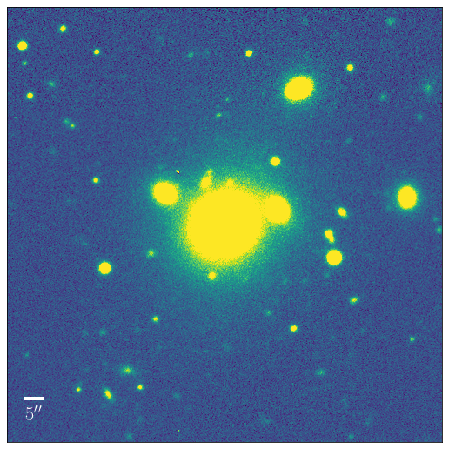

In [10]:
img = fits.open('./decals_cutout.fits')[0].data
display_single(img, pixel_scale=DECaLS_pixel_scale);

### If you want to generate tri-color image cutout using Lupton scheme

In [11]:
# Calculate physical size of a given redshift
def phys_size(redshift, is_print=True, H0=70, Omegam=0.3, Omegal=0.7):
    '''Calculate the corresponding physical size per arcsec of a given redshift
    in the Lambda-CDM cosmology.

    Requirement:
    -----------
    cosmology: https://github.com/esheldon/cosmology
    
    Parameters:
    -----------
    redshift: float
    is_print: boolean. If true, it will print out the physical scale at the given redshift.
    Omegam: float, density parameter of matter. It should be within [0, 1]. 
    Omegal: float, density parameter of Lambda.

    Returns:
    -----------
    physical_size: float, in 'kpc/arcsec'
    '''
    import cosmology
    cosmos = cosmology.Cosmo(H0=H0, omega_m=Omegam, flat=True, omega_l=Omegal, omega_k=None)
    ang_distance = cosmos.Da(0.0, redshift)
    physical_size = ang_distance/206265*1000 # kpc/arcsec
    if is_print:
        print ('At redshift', redshift, ', 1 arcsec =', physical_size, 'kpc')
    return physical_size

In [20]:
# Make tri-color image by ourselves
from astropy.visualization import make_lupton_rgb

size = 150 / phys_size(0.05, is_print=False) / DECaLS_pixel_scale # in pixel
bands = ['z', 'r', 'g']
irg_data = list()

for band in bands:
    url = gen_url_decals(ra, dec, int(size), band, pixel_unit=True)[0]
    fits_data = fits.open(url, cache=False)
    if band == 'z':
        irg_data.append(fits_data[0].data * 0.77)
    else:
        irg_data.append(fits_data[0].data)
    fits_data.close()

# Make Lupton tri-color image
rgb = make_lupton_rgb(irg_data[0], irg_data[1], irg_data[2], Q=10, 
                      stretch=0.05, filename='./lupton-' + 'demo' + '.jpg')

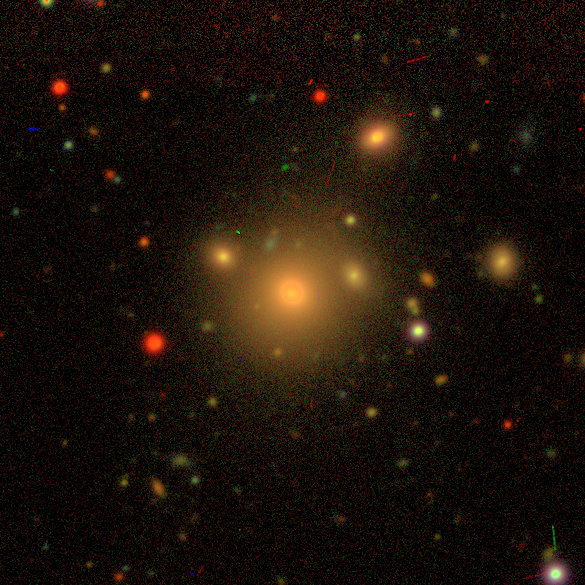

In [22]:
Image.open('./lupton-demo.jpg')

## `the tractor` catalogs: http://legacysurvey.org/dr7/catalogs/
`tractor` residual map: http://legacysurvey.org/viewer#IC%202971